<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap16/16_2_Autoregressive_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 16.2: 1D autoregressive flows**

This notebook investigates a 1D normalizing flows example similar to that illustrated in figure 16.7 in the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First we'll define an invertible one dimensional function as in figure 16.5

In [2]:
# First let's make the 1D piecewise linear mapping as illustrated in figure 16.5
def g(h, phi):
  # TODO -- write this function (equation 16.12)
  # Note: If you have the first printing of the book, there is a mistake in equation 16.12
  # Check the errata for the correct equation (or figure it out yourself!)
  # Replace this line:
  K = len(phi)  # Number of regions
  region_size = 1.0 / K
    
  # Determine which region the input h falls into
  k = int(h * K)
  if k == K:  # Handle edge case when h = 1
      k = K - 1
    
    # Calculate the start point of the current region
  h_start = k * region_size
    
  # Calculate h_prime using the piecewise linear mapping
  h_prime = (sum(phi[:k]) + phi[k] * (h - h_start) / region_size)

  return h_prime

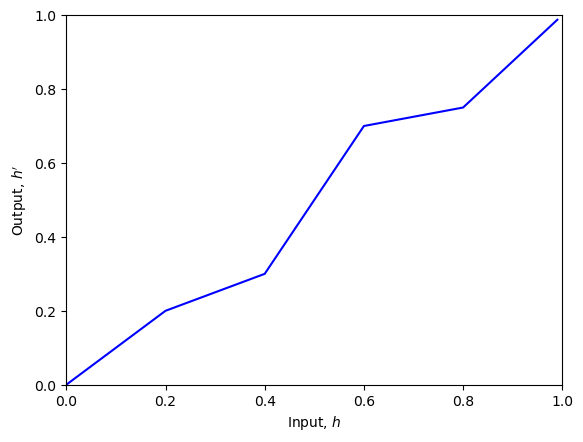

In [3]:
# Let's test this out.  If you managed to vectorize the routine above, then good for you
# but I'll assume you didn't and so we'll use a loop

# Define the parameters
phi = np.array([0.2, 0.1, 0.4, 0.05, 0.25])

# Run the function on an array
h = np.arange(0,1,0.01)
h_prime = np.zeros_like(h)
for i in range(len(h)):
  h_prime[i] = g(h[i], phi)

# Draw the function
fig, ax = plt.subplots()
ax.plot(h,h_prime, 'b-')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Input, $h$')
ax.set_ylabel('Output, $h^\prime$')
plt.show()


We will also need the inverse of this function

In [4]:
# Define the inverse function
def g_inverse(h_prime, phi):
    # Lot's of ways to do this, but we'll just do it by bracketing
    h_low = 0
    h_mid = 0.5
    h_high = 0.999

    thresh = 0.0001
    c_iter = 0
    while(c_iter < 20 and h_high - h_low > thresh):
        h_prime_low = g(h_low, phi)
        h_prime_mid = g(h_mid, phi)
        h_prime_high = g(h_high, phi)
        if h_prime_mid < h_prime:
          h_low = h_mid
        else:
          h_high = h_mid

        h_mid = h_low+(h_high-h_low)/2
        c_iter+=1

    return h_mid

Now let's define an autoregressive flow.  Let's switch to looking at figure 16.7.# We'll assume that our piecewise function will use five parameters phi1,phi2,phi3,phi4,phi5

In [6]:

def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

def softmax(x):
  x = np.exp(x) ;
  x = x/ np.sum(x) ;
  return x

# Return value of phi that doesn't depend on any of the inputs
def get_phi():
  return np.array([0.2, 0.1, 0.4, 0.05, 0.25])

# Compute values of phi that depend on h1
def shallow_network_phi_h1(h1, n_hidden=10):
  # For neatness of code, we'll just define the parameters in the network definition itself
  n_input = 1
  np.random.seed(n_input)
  beta0 = np.random.normal(size=(n_hidden,1))
  Omega0 = np.random.normal(size=(n_hidden, n_input))
  beta1 = np.random.normal(size=(5,1))
  Omega1 = np.random.normal(size=(5, n_hidden))
  return softmax(beta1 + Omega1 @ ReLU(beta0 + Omega0 @ np.array([[h1]])))

# Compute values of phi that depend on h1 and h2
def shallow_network_phi_h1h2(h1,h2,n_hidden=10):
  # For neatness of code, we'll just define the parameters in the network definition itself
  n_input = 2
  np.random.seed(n_input)
  beta0 = np.random.normal(size=(n_hidden,1))
  Omega0 = np.random.normal(size=(n_hidden, n_input))
  beta1 = np.random.normal(size=(5,1))
  Omega1 = np.random.normal(size=(5, n_hidden))
  return softmax(beta1 + Omega1 @ ReLU(beta0 + Omega0 @ np.array([[h1],[h2]])))

# Compute values of phi that depend on h1, h2, and h3
def shallow_network_phi_h1h2h3(h1,h2,h3, n_hidden=10):
  # For neatness of code, we'll just define the parameters in the network definition itself
  n_input = 3
  np.random.seed(n_input)
  beta0 = np.random.normal(size=(n_hidden,1))
  Omega0 = np.random.normal(size=(n_hidden, n_input))
  beta1 = np.random.normal(size=(5,1))
  Omega1 = np.random.normal(size=(5, n_hidden))
  return softmax(beta1 + Omega1 @ ReLU(beta0 + Omega0 @ np.array([[h1],[h2],[h3]])))

The forward mapping as shown in figure 16.7 a

In [7]:
def forward_mapping(h1,h2,h3,h4):
  #TODO implement the forward mapping
  phi1 = get_phi()
  h_prime1 = g(h1, phi1)
    
    # Step 2: Calculate h'2
  phi2 = shallow_network_phi_h1(h1)
  h_prime2 = g(h2, phi2)
    
    # Step 3: Calculate h'3
  phi3 = shallow_network_phi_h1h2(h1, h2)
  h_prime3 = g(h3, phi3)
    
    # Step 4: Calculate h'4
  phi4 = shallow_network_phi_h1h2h3(h1, h2, h3)
  h_prime4 = g(h4, phi4)

  return h_prime1, h_prime2, h_prime3, h_prime4

The backward mapping as shown in figure 16.7b

In [8]:
def backward_mapping(h1_prime,h2_prime,h3_prime,h4_prime):
  #TODO implement the backward mapping
  #Replace this line:
  # Step 1: Calculate h1
  phi1 = get_phi()
  h1 = g_inverse(h1_prime, phi1)
    
  # Step 2: Calculate h2
  phi2 = shallow_network_phi_h1(h1)
  h2 = g_inverse(h2_prime, phi2)
    
  # Step 3: Calculate h3
  phi3 = shallow_network_phi_h1h2(h1, h2)
  h3 = g_inverse(h3_prime, phi3)
    
  # Step 4: Calculate h4
  phi4 = shallow_network_phi_h1h2h3(h1, h2, h3)
  h4 = g_inverse(h4_prime, phi4)

  return h1,h2,h3,h4

Finally, let's make sure that the network really can be inverted

In [9]:
# Test the network to see if it does invert correctly
h1 = 0.22; h2 = 0.41; h3 = 0.83; h4 = 0.53
print("Original h values %3.3f,%3.3f,%3.3f,%3.3f"%(h1,h2,h3,h4))
h1_prime, h2_prime, h3_prime, h4_prime = forward_mapping(h1,h2,h3,h4)
print("h_prime values %3.3f,%3.3f,%3.3f,%3.3f"%(h1_prime,h2_prime,h3_prime,h4_prime))
h1,h2,h3,h4 =  backward_mapping(h1_prime,h2_prime,h3_prime,h4_prime)
print("Reconstructed h values %3.3f,%3.3f,%3.3f,%3.3f"%(h1,h2,h3,h4))

Original h values 0.220,0.410,0.830,0.530
h_prime values 0.210,0.025,0.409,0.086
Reconstructed h values 0.220,0.410,0.830,0.530


C:\Users\davi8\AppData\Local\Temp\ipykernel_36600\1221913581.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("h_prime values %3.3f,%3.3f,%3.3f,%3.3f"%(h1_prime,h2_prime,h3_prime,h4_prime))
